In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
from utils import get_ray_directions, get_rays
import os
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Tuple
import lightning as L
from rendering import rendering

from dataset import LegoDataset, LegoDataModule
from model import Nerf

In [2]:
lego_dataset = LegoDataset(
    root_dir="dataset/lego/", split="test", img_shape=(200, 200)
)

In [10]:
train_dataloader = DataLoader(
    torch.cat(
        (
            lego_dataset.all_rays_origin.type(torch.float),
            lego_dataset.all_rays_direction.type(torch.float),
            lego_dataset.all_rgbs.type(torch.float),
        ),
        dim=1,
    ),
    batch_size=1024,
    num_workers=3,
    shuffle=True,
)

image_1_4 = int(lego_dataset.img_shape[0] * (1 / 4))
image_3_4 = int(lego_dataset.img_shape[0] * (3 / 4))
warmup_dataloader = DataLoader(
    torch.cat(
        (
            lego_dataset.all_rays_origin.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
            lego_dataset.all_rays_direction.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
            lego_dataset.all_rgbs.reshape(
                len(lego_dataset),
                lego_dataset.img_shape[0],
                lego_dataset.img_shape[1],
                3,
            )[:, image_1_4:image_3_4, image_1_4:image_3_4, :]
            .reshape(-1, 3)
            .type(torch.float),
        ),
        dim=1,
    ),
    batch_size=1024,
    num_workers=3,
    shuffle=True,
)

In [4]:
lego_dataset.all_rays_origin[0]

tensor([-0.0538,  3.8455,  1.2081], dtype=torch.float64)

In [7]:
len(warmup_dataloader)

3907

In [11]:
def training(
    model, optimizer, scheduler, dataloader, tn, tf, nb_bins, nb_epochs, device="cpu"
):

    training_loss = []

    progress_bar = tqdm(
        enumerate(dataloader),
        total=len(dataloader),
    )

    for epoch in range(nb_epochs):
        progress_bar.set_description(f"Training Epoch: {epoch}")
        for idx, batch in progress_bar:
            origin = batch[:, :3].to(device)
            direction = batch[:, 3:6].to(device)

            target = batch[:, 6:].to(device)

            prediction = rendering(model, origin, direction, tn, tf, nb_bins, device)

            loss = ((prediction - target) ** 2).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({"loss": loss.item()})
            training_loss.append(loss.item())

        scheduler.step()

        torch.save(model.cpu(), "models/model_nerf")
        model.to(device)

In [1]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparams
tn = 2.0
tf = 6.0
nb_epochs = 16
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

model = Nerf().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[2, 4, 8], gamma=gamma
)


# warmup on 1 epoch
training_loss = training(
    model, optimizer, scheduler, warmup_dataloader, tn, tf, nb_bins, 1, device
)
plt.plot(training_loss)
plt.show()

# training_loss = training(model, optimizer, scheduler, train_dataloader, tn, tf, nb_bins, nb_epochs, device)
# plt.plot(training_loss)
# plt.show()

NameError: name 'torch' is not defined

In [6]:
torch.save(model.cpu(), "models/model_nerf")
model.to(device)

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=257, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
    (3): Si

In [22]:
lego_dataset.all_rays_direction.reshape(100, -1, 3)[0].shape
lego_dataset.all_rays_origin.reshape(100, -1, 3)[0].shape

torch.Size([160000, 3])

In [4]:
def mse2psnr(mse_loss):
    return 20 * np.log10(1 / np.sqrt(mse_loss))

from pathlib import Path
@torch.inference_mode()
def test(
    model,
    origin,
    direction,
    tn,
    tf,
    image_index,
    nb_bins=100,
    chunk_size=20,
    height=400,
    width=400,
    target=None,
    outputs_dir = None,
    title=True
):
    
    save_dir = Path(outputs_dir)
    save_dir.mkdir(exist_ok=True,
                   parents=True)
    
    with torch.inference_mode():
        model.eval()
        origin = origin.chunk(chunk_size)
        direction = direction.chunk(chunk_size)

        image = []
        for origin_batch, direction_batch in zip(
            origin, direction
        ):  # zip to interate both lists at the same time
            img_batch = rendering(
                model,
                origin_batch,
                direction_batch,
                tn,
                tf,
                nb_bins,
                device=origin_batch.device,
            )
            image.append(img_batch)  # [N, 3]

        image = torch.cat(image)  # [H*W, 3]
        image = (
            image.reshape(height, width, 3).cpu().numpy()
        )  # no need for .data as there are no gradients!

        if target is not None:
            loss = ((image - target) ** 2).mean()  # same as mean squared errorfunction
            psnr = mse2psnr(loss)
            
            if outputs_dir is not None:
                if title:
                    plt.title(f"MSE: {loss:.4f} || PSNR: {psnr:.4f}")
                plt.imshow(image)
                plt.savefig(f"{outputs_dir}/lego_{image_index}.png", bbox_inches = 'tight')
            return image, loss, psnr

        else:
            if outputs_dir is not None:
                plt.imshow(image)
                plt.savefig(f"{outputs_dir}/lego_{image_index}.png", bbox_inches = 'tight') 
            return image
        
        

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nerf_model = torch.load('models/model_nerf').to(device)
nerf_model.eval()

# hyperparams
tn = 2.0
tf = 6.0
nb_epochs = 16
learning_rate = 1e-3
gamma = 0.5
nb_bins = 100

In [71]:
lego_dataset.all_rays_origin.reshape(100,-1,3).shape

AttributeError: 'LegoDataset' object has no attribute 'all_rays_origin'

In [73]:
lego_dataset[199]['rays_origin'].shape
# lego_dataset[0]['rays_direction']
# lego_dataset[0]['rgbs']

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:69: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([200, 200, 3])

In [61]:
index = 11
#on train set
img, mse, psnr = test(
    nerf_model,
    lego_dataset.all_rays_origin.reshape(100, -1, 3)[index].to(device).type(torch.float),
    lego_dataset.all_rays_direction.reshape(100, -1, 3)[index].to(device).type(torch.float),
    tn,
    tf,
    image_index=index,
    nb_bins=100,
    chunk_size=20,
    height=lego_dataset.img_shape[0],
    width=lego_dataset.img_shape[1],
    target=lego_dataset.all_rgbs.reshape(100, 200, 200, 3)[index].numpy(),
    outputs_dir='nerf_test'
)

# plt.title(f"mse loss: {mse:.4f} || psnr: {psnr:.4f}")
# plt.imshow(img)
# plt.savefig(f"test.png", bbox_inches = 'tight')


AttributeError: 'LegoDataset' object has no attribute 'all_rays_origin'

/home/stanley/Documents/shid/nerf_pytorch_lightning/utils.py:70: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..25

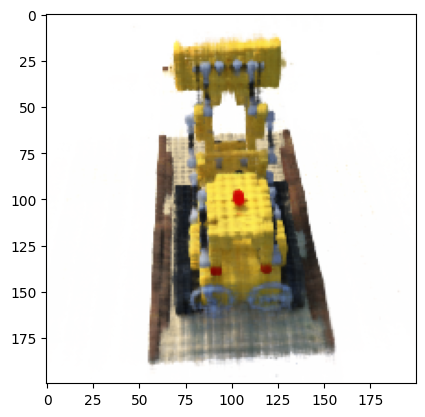

In [5]:
for idx in range(51, 200):
    img, mse, psnr = test(
    nerf_model,
    lego_dataset[idx]['rays_origin'].reshape(-1, 3).to(device).type(torch.float),
    lego_dataset[idx]['rays_direction'].reshape(-1, 3).to(device).type(torch.float),
    tn,
    tf,
    image_index=idx,
    nb_bins=100,
    chunk_size=20,
    height=lego_dataset.img_shape[0],
    width=lego_dataset.img_shape[1],
    target=lego_dataset[idx]['rgbs'].numpy(),
    outputs_dir='nerf_test',
    title=False
)
